In [ ]:
# This code is used to compare the annual average GPP, Reco, and NEE fluxes from the updated UrbanVPRM and SMUrF model
# for the year 2018 - 2021. Since these models do not capture uncertainties at annual scales, we assume the annual percent
# uncertainty is the same as the SMUrF hourly percent uncertainty.

# This code recreates supplemental figure S8 in Madsen-Colford et al. 2025

#Portions of the code that should be changed by the user are denoted by *** in the comment above

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import optimize as opt 
from scipy import odr
import shapefile as shp # to import outline of GTA
from shapely import geometry # used to define a polygon for Toronto
import netCDF4
from netCDF4 import Dataset, date2num #for reading netCDF data files and their date (not sure if I need the later)

In [2]:
# *** CHANGE YEAR, PATH NAME AND FILENAME ***
yr=2018
VPRM_path = 'E:/Research/UrbanVPRM/dataverse_files/GTA_V061_500m_'+str(yr)+'/' 
VPRM_fn = 'vprm_GMIS_Toronto_ACI_SOLRIS_ISA_500m_GTA_V061_'+str(yr)+'_no_PScale_adjusted_Topt_Ra_URB_parameters_fixed_gapfilled_LSWI_filtered_bilinear_PAR_block_'

VPRM_data=pd.read_csv(VPRM_path+VPRM_fn+'00000001.csv').loc[:,('HoY','Index','GEE','Re')]

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00002501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00005001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00007501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00010001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00012501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

In [3]:
#Load in Index, x, & y data and merge that with UrbanVPRM flux data
# *** CHANGE EVI FILENAME ***
VPRM_EVI=pd.read_csv(VPRM_path+'adjusted_evi_lswi_interpolated_modis_v061_qc_filtered_LSWI_filtered.csv').loc[:,('DOY','Index','x','y')]

#Create a dataframe with just Index, x, & y values
x=np.zeros(np.shape(VPRM_EVI.Index.unique()))*np.nan
y=np.zeros(np.shape(VPRM_EVI.Index.unique()))*np.nan
for i in range(len(VPRM_EVI.Index.unique())):
    x[i]=VPRM_EVI.x[0+i*365]
    y[i]=VPRM_EVI.y[0+i*365]
    
VPRM_xy=pd.DataFrame({'Index':VPRM_EVI.Index.unique(), 'x':x, 'y':y})
VPRM_data=VPRM_data.merge(VPRM_xy[['Index','x','y']])
del VPRM_EVI, VPRM_xy

In [4]:
#Extract unique x & y values
xvals = VPRM_data.x[VPRM_data.HoY==4800].unique()
yvals = VPRM_data.y[VPRM_data.HoY==4800].unique()
extent = np.min(xvals), np.max(xvals), np.min(yvals), np.max(yvals)

# Rearrange the GPP and Reco data into an array
GPP=-VPRM_data.GEE.values.reshape(len(yvals),len(xvals),8760)#8784 for leap year
Reco=VPRM_data.Re.values.reshape(len(yvals),len(xvals),8760)

In [5]:
#Import shapefile for the city of Toronto

#*** CHANGE PATH AND FILENAME ***
sf = shp.Reader("C:/Users/kitty/Documents/Research/SIF/Shape_files/Toronto/Toronto_Boundary.shp")
#Toronto_Shape
shape=sf.shape(0)
Toronto_x = np.zeros((len(shape.points),1))*np.nan
Toronto_y = np.zeros((len(shape.points),1))*np.nan
for i in range(len(shape.points)):
    Toronto_x[i]=shape.points[i][0]
    Toronto_y[i]=shape.points[i][1]
    
points=[]
for k in range(1,len(Toronto_x)):
    points.append(geometry.Point(Toronto_x[k],Toronto_y[k]))
poly=geometry.Polygon([[p.x, p.y] for p in points])

#Create a mask for areas outside of Toronto
lons=np.ones(144)*np.nan
lats=np.ones(96)*np.nan
GPP_mask=np.ones([96,144])*np.nan
for i in range(0, len(lons)):
    for j in range(0, len(lats)):
        if poly.contains(geometry.Point([xvals[i],yvals[j]])):
            lons[i]=xvals[i]
            lats[j]=yvals[j]
            GPP_mask[j,i]=1

In [6]:
# Apply Toronto mask to UrbanVPRM flux data
T_VPRM_GPP=GPP*GPP_mask[:,:,np.newaxis]
T_VPRM_Reco=Reco*GPP_mask[:,:,np.newaxis]
T_VPRM_NEE=Reco-GPP

In [7]:
# Take the annual average of Toronto UrbanVPRM flux data
T_VPRM_GPP_2018_avg = np.nanmean(T_VPRM_GPP)
T_VPRM_Reco_2018_avg = np.nanmean(T_VPRM_Reco)
T_VPRM_NEE_2018_avg = np.nanmean(T_VPRM_NEE)

In [8]:
del T_VPRM_GPP, T_VPRM_Reco, T_VPRM_NEE, GPP, Reco, VPRM_data

In [11]:
del sf, shape, points, poly

In [12]:
#now bring in the SMUrF data

# *** CHANGE PATH ***
SMUrF_path = 'C:/Users/kitty/Documents/Research/SIF/SMUrF/output2018_500m_CSIF_to_TROPOMI_CSIF_ALL_converted_slps_V3_temp_impervious_R_shore_corr_V061_8day/easternCONUS/'
# *** CHANGE FILE NAME ***
SMUrF_fn = 'daily_mean_Reco_ISA_a_neuralnet/era5/2018/daily_mean_Reco_uncert_GMIS_Toronto_t_easternCONUS_2018' #Filename WITHOUT month or day

g=Dataset(SMUrF_path+SMUrF_fn+'0101.nc')
start_of_year=g.variables['time'][0]/3600/24-1 #convert seconds since 1970 to days (minus one)

g.close()

#With ISA adjustment using GMIS-Toronto-SOLRIS-ACI dataset
S_time_2018=[]
S_Reco=[]
S_Reco_err=[]
S_lats_8day=[]
S_lons_8day=[]
for j in range(1,13):
    for i in range(1,32):
        try:
            if j<10:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+str(i)+'.nc')
            else:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+str(i)+'.nc')
            if len(S_time_2018)==0:
                S_lats_8day=f.variables['lat'][:]
                S_lons_8day=f.variables['lon'][:]
                S_Reco=f.variables['Reco_mean'][:]
                S_Reco_err=f.variables['Reco_sd'][:]
                S_time_2018=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year
            else:
                S_Reco=np.concatenate((S_Reco,f.variables['Reco_mean'][:]),axis=0)
                S_Reco_err=np.concatenate((S_Reco_err,f.variables['Reco_sd'][:]),axis=0)
                S_time_2018=np.concatenate((S_time_2018,(f.variables['time'][:]/24/3600-start_of_year-5/24)),axis=0)
            f.close()
        except FileNotFoundError:
            pass
        
#Load in SMUrF GPP data
# *** CHANGE GPP FILENAME ***
f=Dataset(SMUrF_path+'daily_mean_SIF_GPP_uncert_easternCONUS_2018.nc')
S_time_8day_2018=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year

S_GPP_err_8day=f.variables['GPP_sd'][:]
S_GPP_8day=f.variables['GPP_mean'][:]

# Replace fill values with NaN
S_Reco[S_Reco==-999]=np.nan
S_Reco_err[S_Reco_err==-999]=np.nan
S_GPP_8day[S_GPP_8day==-999]=np.nan
S_GPP_err_8day[S_GPP_err_8day==-999]=np.nan

# Take 8-day average of Reco data to match temporal resolution of GPP
S_Reco_8day=np.ones(np.shape(S_GPP_8day))*np.nan
S_Reco_err_8day=np.ones(np.shape(S_GPP_8day))*np.nan
S_Reco_std_8day=np.ones(np.shape(S_GPP_8day))*np.nan
for i in range(len(S_time_8day_2018)):
    S_Reco_8day[i]=np.nanmean(S_Reco[i*8:i*8+8],axis=0)
    S_Reco_err_8day[i]=np.sqrt(np.nansum((S_Reco_err[i*8:i*8+8]/4)**2,axis=0))
    S_Reco_std_8day[i]=np.nanstd(S_Reco[i*8:i*8+8],axis=0)

#Compute 8day resolution NEE data
S_NEE_8day=S_Reco_8day-S_GPP_8day
S_NEE_err_8day=np.sqrt(S_Reco_err_8day**2+S_GPP_err_8day**2)

# Select data only over Toronto
T_S_GPP_2018=S_GPP_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_2018=S_Reco_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_2018=S_NEE_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

T_S_GPP_err_2018=S_GPP_err_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_err_2018=S_Reco_err_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_err_2018=S_NEE_err_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
C:\Users\kitty\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [13]:
# Take the annual average of SMUrF fluxes over Toronto

T_S_GPP_2018_avg = np.nanmean(T_S_GPP_2018)
T_S_Reco_2018_avg = np.nanmean(T_S_Reco_2018)
T_S_NEE_2018_avg = np.nanmean(T_S_NEE_2018)

T_S_GPP_2018_err_perc_avg = np.nanmean(T_S_GPP_err_2018/T_S_GPP_2018)
T_S_Reco_2018_err_perc_avg = np.nanmean(T_S_Reco_err_2018/T_S_Reco_2018)
T_S_NEE_2018_err_perc_avg = np.nanmean(T_S_NEE_err_2018/T_S_NEE_2018)

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [14]:
del T_S_GPP_2018, T_S_Reco_2018, T_S_NEE_2018, S_GPP_8day, S_Reco_8day, S_NEE_8day, T_S_GPP_err_2018, T_S_Reco_err_2018, T_S_NEE_err_2018, S_NEE_err_8day, S_GPP_err_8day, S_Reco_err_8day

In [15]:
del S_Reco, S_Reco_err, S_Reco_std_8day, S_lats_8day, S_lons_8day, S_time_2018, S_time_8day_2018

In [16]:
# *** CHANGE YEAR, PATH NAME AND FILENAME ***
yr=2019
VPRM_path = 'E:/Research/UrbanVPRM/dataverse_files/GTA_V061_500m_'+str(yr)+'/'
VPRM_fn = 'vprm_GMIS_Toronto_ACI_SOLRIS_ISA_500m_GTA_V061_'+str(yr)+'_no_PScale_adjusted_Topt_Ra_URB_parameters_fixed_gapfilled_LSWI_filtered_bilinear_PAR_block_'

VPRM_data=pd.read_csv(VPRM_path+VPRM_fn+'00000001.csv').loc[:,('HoY','Index','GEE','Re')]

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00002501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00005001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00007501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00010001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00012501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

In [17]:
GPP=-VPRM_data.GEE.values.reshape(len(yvals),len(xvals),8760)#8784 for leap year
Reco=VPRM_data.Re.values.reshape(len(yvals),len(xvals),8760)

T_VPRM_GPP=GPP*GPP_mask[:,:,np.newaxis]
T_VPRM_Reco=Reco*GPP_mask[:,:,np.newaxis]
T_VPRM_NEE=Reco-GPP

T_VPRM_GPP_2019_avg = np.nanmean(T_VPRM_GPP)
T_VPRM_Reco_2019_avg = np.nanmean(T_VPRM_Reco)
T_VPRM_NEE_2019_avg = np.nanmean(T_VPRM_NEE)

In [18]:
del T_VPRM_GPP, T_VPRM_Reco, T_VPRM_NEE, GPP, Reco, VPRM_data

In [19]:
#now bring in the SMUrF data

# *** CHANGE PATH ***
SMUrF_path = 'E:/Research/SMUrF/output2019_500m_CSIF_to_TROPOMI_CSIF_ALL_converted_slps_V3_temp_impervious_R_shore_corr_V061_8day/easternCONUS/'
# *** CHANGE FILE NAME ***
SMUrF_fn = 'daily_mean_Reco_ISA_a_neuralnet/era5/2019/daily_mean_Reco_uncert_GMIS_Toronto_easternCONUS_2019' #Filename WITHOUT month or day

g=Dataset(SMUrF_path+SMUrF_fn+'0101.nc')
start_of_year=g.variables['time'][0]/3600/24-1 #convert seconds since 1970 to days (minus one)

g.close()

#With ISA adjustment using GMIS-Toronto-SOLRIS-ACI dataset
S_time_2019=[]
S_Reco=[]
S_Reco_err=[]
S_lats_8day=[]
S_lons_8day=[]
for j in range(1,13):
    for i in range(1,32):
        try:
            if j<10:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+str(i)+'.nc')
            else:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+str(i)+'.nc')
            if len(S_time_2019)==0:
                S_lats_8day=f.variables['lat'][:]
                S_lons_8day=f.variables['lon'][:]
                S_Reco=f.variables['Reco_mean'][:]
                S_Reco_err=f.variables['Reco_sd'][:]
                S_time_2019=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year
            else:
                S_Reco=np.concatenate((S_Reco,f.variables['Reco_mean'][:]),axis=0)
                S_Reco_err=np.concatenate((S_Reco_err,f.variables['Reco_sd'][:]),axis=0)
                S_time_2019=np.concatenate((S_time_2019,(f.variables['time'][:]/24/3600-start_of_year-5/24)),axis=0)
            f.close()
        except FileNotFoundError:
            pass
        
#Load in SMUrF GPP data
f=Dataset(SMUrF_path+'daily_mean_SIF_GPP_uncert_easternCONUS_2019.nc')
S_time_8day_2019=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year

S_GPP_err_8day=f.variables['GPP_sd'][:]
S_GPP_8day=f.variables['GPP_mean'][:]

# Replace fill values with NaN
S_Reco[S_Reco==-999]=np.nan
S_Reco_err[S_Reco_err==-999]=np.nan
S_GPP_8day[S_GPP_8day==-999]=np.nan
S_GPP_err_8day[S_GPP_err_8day==-999]=np.nan

# Take 8-day average of Reco data to match temporal resolution of GPP
S_Reco_8day=np.ones(np.shape(S_GPP_8day))*np.nan
S_Reco_err_8day=np.ones(np.shape(S_GPP_8day))*np.nan
S_Reco_std_8day=np.ones(np.shape(S_GPP_8day))*np.nan
for i in range(len(S_time_8day_2019)):
    S_Reco_8day[i]=np.nanmean(S_Reco[i*8:i*8+8],axis=0)
    S_Reco_err_8day[i]=np.sqrt(np.nansum((S_Reco_err[i*8:i*8+8]/4)**2,axis=0))
    S_Reco_std_8day[i]=np.nanstd(S_Reco[i*8:i*8+8],axis=0)

#Compute 8day resolution NEE data
S_NEE_8day=S_Reco_8day-S_GPP_8day
S_NEE_err_8day=np.sqrt(S_Reco_err_8day**2+S_GPP_err_8day**2)

# Select data only over Toronto
T_S_GPP_2019=S_GPP_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_2019=S_Reco_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_2019=S_NEE_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

T_S_GPP_err_2019=S_GPP_err_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_err_2019=S_Reco_err_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_err_2019=S_NEE_err_8day[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

# Take the annual average of SMUrF fluxes over Toronto

T_S_GPP_2019_avg = np.nanmean(T_S_GPP_2019)
T_S_Reco_2019_avg = np.nanmean(T_S_Reco_2019)
T_S_NEE_2019_avg = np.nanmean(T_S_NEE_2019)

T_S_GPP_2019_err_perc_avg = np.nanmean(T_S_GPP_err_2019/T_S_GPP_2019)
T_S_Reco_2019_err_perc_avg = np.nanmean(T_S_Reco_err_2019/T_S_Reco_2019)
T_S_NEE_2019_err_perc_avg = np.nanmean(T_S_NEE_err_2019/T_S_NEE_2019)

del T_S_GPP_2019, T_S_Reco_2019, T_S_NEE_2019, S_GPP_8day, S_Reco_8day, S_NEE_8day, T_S_GPP_err_2019, T_S_Reco_err_2019, T_S_NEE_err_2019, S_NEE_err_8day, S_GPP_err_8day, S_Reco_err_8day
del S_Reco, S_Reco_err, S_Reco_std_8day, S_lats_8day, S_lons_8day, S_time_2019, S_time_8day_2019

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


In [20]:
# *** CHANGE YEAR, PATH NAME AND FILENAME ***
yr=2020
VPRM_path = 'E:/Research/UrbanVPRM/dataverse_files/GTA_V061_500m_'+str(yr)+'/'
VPRM_fn = 'vprm_GMIS_Toronto_ACI_SOLRIS_ISA_500m_GTA_V061_'+str(yr)+'_no_PScale_adjusted_Topt_Ra_URB_parameters_fixed_gapfilled_LSWI_filtered_bilinear_PAR_block_'

VPRM_data=pd.read_csv(VPRM_path+VPRM_fn+'00000001.csv').loc[:,('HoY','Index','GEE','Re')]

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00002501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00005001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00007501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00010001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00012501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

In [21]:
GPP=-VPRM_data.GEE.values.reshape(len(yvals),len(xvals),8784)#8784 for leap year
Reco=VPRM_data.Re.values.reshape(len(yvals),len(xvals),8784)

T_VPRM_GPP=GPP*GPP_mask[:,:,np.newaxis]
T_VPRM_Reco=Reco*GPP_mask[:,:,np.newaxis]
T_VPRM_NEE=Reco-GPP

T_VPRM_GPP_2020_avg = np.nanmean(T_VPRM_GPP)
T_VPRM_Reco_2020_avg = np.nanmean(T_VPRM_Reco)
T_VPRM_NEE_2020_avg = np.nanmean(T_VPRM_NEE)

In [22]:
T_VPRM_GPP_2020_std_err = np.nanstd(T_VPRM_GPP)/np.sqrt(np.sum(np.isnan(T_VPRM_GPP)==False))
T_VPRM_Reco_2020_std_err = np.nanstd(T_VPRM_Reco)/np.sqrt(np.sum(np.isnan(T_VPRM_GPP)==False))
T_VPRM_NEE_2020_std_err = np.nanstd(T_VPRM_NEE)/np.sqrt(np.sum(np.isnan(T_VPRM_GPP)==False))

T_VPRM_GPP_2020_std = np.nanstd(T_VPRM_GPP)
T_VPRM_Reco_2020_std = np.nanstd(T_VPRM_Reco)
T_VPRM_NEE_2020_std = np.nanstd(T_VPRM_NEE)

In [23]:
del T_VPRM_GPP, T_VPRM_Reco, T_VPRM_NEE, GPP, Reco, VPRM_data

In [26]:
#now bring in the 2020 SMUrF data
# *** CHANGE PATH ***
SMUrF_path = 'E:/Research/SMUrF/output2020_500m_CSIF_to_TROPOMI_CSIF_ALL_converted_slps_temp_impervious_R_V061_8day/easternCONUS/'
# *** CHANGE FILENAME ***
SMUrF_fn = 'daily_mean_Reco_ISA_a_neuralnet/era5/2020/daily_mean_Reco_uncert_GMIS_Toronto_fixed_border_easternCONUS_2020' #Filename WITHOUT month or day


g=Dataset(SMUrF_path+SMUrF_fn+'0101.nc')
start_of_year=g.variables['time'][0]/3600/24-1 #convert seconds since 1970 to days (minus one)
g.close()



#With ISA adjustment using GMIS-Toronto-SOLRIS-ACI dataset
S_time_2020=[]
S_Reco=[]
S_Reco_err=[]
S_lats_8day=[]
S_lons_8day=[]
for j in range(1,13):
    for i in range(1,32):
        try:
            if j<10:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+str(i)+'.nc')                
            else:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+'0'+str(i)+'.nc') 
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+str(i)+'.nc')
            if len(S_time_2020)==0:
                S_lats_8day=f.variables['lat'][:]
                S_lons_8day=f.variables['lon'][:]
                S_Reco=f.variables['Reco_mean'][:]
                S_Reco_err=f.variables['Reco_sd'][:]
                S_time_2020=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year
            else:
                S_Reco=np.concatenate((S_Reco,f.variables['Reco_mean'][:]),axis=0)
                S_Reco_err=np.concatenate((S_Reco_err,f.variables['Reco_sd'][:]),axis=0)
                S_time_2020=np.concatenate((S_time_2020,(f.variables['time'][:]/24/3600-start_of_year-5/24)),axis=0)
            f.close()
        except FileNotFoundError:
            pass
        
#If on external harddrive
#*** CHANGE GPP FILENAME ***
f=Dataset(SMUrF_path+'/daily_mean_SIF_GPP_uncert_easternCONUS_2020.nc')
S_time_8day_2020=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year

S_GPP_err_8day_2020=f.variables['GPP_sd'][:]
S_GPP_8day_2020=f.variables['GPP_mean'][:]

S_Reco[S_Reco==-999]=np.nan
S_Reco_err[S_Reco_err==-999]=np.nan
S_GPP_8day_2020[S_GPP_8day_2020==-999]=np.nan
S_GPP_err_8day_2020[S_GPP_err_8day_2020==-999]=np.nan

S_Reco_8day_2020=np.ones(np.shape(S_GPP_8day_2020))*np.nan
S_Reco_err_8day_2020=np.ones(np.shape(S_GPP_8day_2020))*np.nan
S_Reco_std_8day_2020=np.ones(np.shape(S_GPP_8day_2020))*np.nan
for i in range(len(S_time_8day_2020)):
    S_Reco_8day_2020[i]=np.nanmean(S_Reco[i*8:i*8+8],axis=0)
    S_Reco_err_8day_2020[i]=np.sqrt(np.nansum((S_Reco_err[i*8:i*8+8]/4)**2,axis=0))
    S_Reco_std_8day_2020[i]=np.nanstd(S_Reco[i*8:i*8+8],axis=0)
    
S_NEE_8day_2020=S_Reco_8day_2020-S_GPP_8day_2020
S_NEE_err_8day_2020=np.sqrt(S_Reco_err_8day_2020**2+S_GPP_err_8day_2020**2)

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


In [27]:
T_S_GPP_2020=S_GPP_8day_2020[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_2020=S_Reco_8day_2020[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_2020=S_NEE_8day_2020[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

T_S_GPP_err_2020=S_GPP_err_8day_2020[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_err_2020=S_Reco_err_8day_2020[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_err_2020=S_NEE_err_8day_2020[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

T_S_GPP_2020_avg = np.nanmean(T_S_GPP_2020)
T_S_Reco_2020_avg = np.nanmean(T_S_Reco_2020)
T_S_NEE_2020_avg = np.nanmean(T_S_NEE_2020)

T_S_GPP_2020_err_perc_avg = np.nanmean(T_S_GPP_err_2020/T_S_GPP_2020)
T_S_Reco_2020_err_perc_avg = np.nanmean(T_S_Reco_err_2020/T_S_Reco_2020)
T_S_NEE_2020_err_perc_avg = np.nanmean(T_S_NEE_err_2020/T_S_NEE_2020)

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [28]:
del T_S_GPP_2020, T_S_Reco_2020, T_S_NEE_2020, S_GPP_8day_2020, S_Reco_8day_2020, S_NEE_8day_2020, T_S_GPP_err_2020, T_S_Reco_err_2020, T_S_NEE_err_2020, S_NEE_err_8day_2020, S_GPP_err_8day_2020, S_Reco_err_8day_2020

In [29]:
del S_lats_8day, S_lons_8day, S_time_2020, S_time_8day_2020

In [30]:
yr=2021
VPRM_path = 'E:/Research/UrbanVPRM/dataverse_files/GTA_V061_500m_'+str(yr)+'/'
VPRM_fn = 'vprm_GMIS_Toronto_ACI_SOLRIS_ISA_500m_GTA_V061_'+str(yr)+'_no_PScale_adjusted_Topt_Ra_URB_parameters_fixed_gapfilled_LSWI_QA_fixed_filtered_bilinear_PAR_block_'

VPRM_data=pd.read_csv(VPRM_path+VPRM_fn+'00000001.csv').loc[:,('HoY','Index','GEE','Re')]

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00002501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00005001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00007501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00010001.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

VPRM_data2=pd.read_csv(VPRM_path+VPRM_fn+'00012501.csv').loc[:,('HoY','Index','GEE','Re')]
VPRM_data=VPRM_data.append(VPRM_data2)
del VPRM_data2

In [31]:
GPP=-VPRM_data.GEE.values.reshape(len(yvals),len(xvals),8760)#8784 for leap year
Reco=VPRM_data.Re.values.reshape(len(yvals),len(xvals),8760)

T_VPRM_GPP=GPP*GPP_mask[:,:,np.newaxis]
T_VPRM_Reco=Reco*GPP_mask[:,:,np.newaxis]
T_VPRM_NEE=Reco-GPP

T_VPRM_GPP_2021_avg = np.nanmean(T_VPRM_GPP)
T_VPRM_Reco_2021_avg = np.nanmean(T_VPRM_Reco)
T_VPRM_NEE_2021_avg = np.nanmean(T_VPRM_NEE)

In [32]:
T_VPRM_GPP_2021_std_err = np.nanstd(T_VPRM_GPP)/np.sqrt(np.sum(np.isnan(T_VPRM_GPP)==False))
T_VPRM_Reco_2021_std_err = np.nanstd(T_VPRM_Reco)/np.sqrt(np.sum(np.isnan(T_VPRM_GPP)==False))
T_VPRM_NEE_2021_std_err = np.nanstd(T_VPRM_NEE)/np.sqrt(np.sum(np.isnan(T_VPRM_GPP)==False))

T_VPRM_GPP_2021_std = np.nanstd(T_VPRM_GPP)
T_VPRM_Reco_2021_std = np.nanstd(T_VPRM_Reco)
T_VPRM_NEE_2021_std = np.nanstd(T_VPRM_NEE)

In [33]:
del T_VPRM_GPP, T_VPRM_Reco, T_VPRM_NEE, GPP, Reco, VPRM_data

In [34]:
#now bring in the 2021 SMUrF data
# *** CHANGE PATH ***
SMUrF_path = 'E:/Research/SMUrF/output2021_500m_CSIF_to_TROPOMI_CSIF_ALL_converted_slps_temp_impervious_R_V061_8day/easternCONUS/'
# *** CHANGE FILENAME ***
SMUrF_fn = 'daily_mean_Reco_ISA_a_neuralnet/era5/2021/daily_mean_Reco_uncert_GMIS_Toronto_fixed_border_easternCONUS_2021' #Filename WITHOUT month or day

g=Dataset(SMUrF_path+SMUrF_fn+'0101.nc')
#g=Dataset('E:/Research/SMUrF/output2021_CSIF_temp_8day/easternCONUS/daily_mean_Reco_neuralnet/era5/2021/daily_mean_Reco_uncert_easternCONUS_20210101.nc')
start_of_year=g.variables['time'][0]/3600/24-1 #convert seconds since 1970 to days (minus one)

g.close()

#With ISA adjustment using GMIS-Toronto-SOLRIS-ACI dataset
S_time_2021=[]
S_Reco=[]
S_Reco_err=[]
S_lats_8day=[]
S_lons_8day=[]
for j in range(1,13):
    for i in range(1,32):
        try:
            if j<10:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+'0'+str(j)+str(i)+'.nc')
            else:
                if i<10:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+'0'+str(i)+'.nc')
                else:
                    f=Dataset(SMUrF_path+SMUrF_fn+str(j)+str(i)+'.nc')
            if len(S_time_2021)==0:
                S_lats_8day=f.variables['lat'][:]
                S_lons_8day=f.variables['lon'][:]
                S_Reco=f.variables['Reco_mean'][:]
                S_Reco_err=f.variables['Reco_sd'][:]
                S_time_2021=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year
            else:
                S_Reco=np.concatenate((S_Reco,f.variables['Reco_mean'][:]),axis=0)
                S_Reco_err=np.concatenate((S_Reco_err,f.variables['Reco_sd'][:]),axis=0)
                S_time_2021=np.concatenate((S_time_2021,(f.variables['time'][:]/24/3600-start_of_year-5/24)),axis=0)
            f.close()
        except FileNotFoundError:
            pass
        
# *** CHANGE GPP FILENAME ***
f=Dataset(SMUrF_path+'daily_mean_SIF_GPP_uncert_easternCONUS_2021.nc')
S_time_8day_2021=f.variables['time'][:]/24/3600-start_of_year-5/24 #convert seconds since 1970 to days and subtract start of year

S_GPP_err_8day_2021=f.variables['GPP_sd'][:]
S_GPP_8day_2021=f.variables['GPP_mean'][:]

S_Reco[S_Reco==-999]=np.nan
S_Reco_err[S_Reco_err==-999]=np.nan
S_GPP_8day_2021[S_GPP_8day_2021==-999]=np.nan
S_GPP_err_8day_2021[S_GPP_err_8day_2021==-999]=np.nan

S_Reco_8day_2021=np.ones(np.shape(S_GPP_8day_2021))*np.nan
S_Reco_err_8day_2021=np.ones(np.shape(S_GPP_8day_2021))*np.nan
S_Reco_std_8day_2021=np.ones(np.shape(S_GPP_8day_2021))*np.nan
for i in range(len(S_time_8day_2021)):
    S_Reco_8day_2021[i]=np.nanmean(S_Reco[i*8:i*8+8],axis=0)
    S_Reco_err_8day_2021[i]=np.sqrt(np.nansum((S_Reco_err[i*8:i*8+8]/4)**2,axis=0))
    S_Reco_std_8day_2021[i]=np.nanstd(S_Reco[i*8:i*8+8],axis=0)
    
S_NEE_8day_2021=S_Reco_8day_2021-S_GPP_8day_2021
S_NEE_err_8day_2021=np.sqrt(S_Reco_err_8day_2021**2+S_GPP_err_8day_2021**2)

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


In [35]:
T_S_GPP_2021=S_GPP_8day_2021[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_2021=S_Reco_8day_2021[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_2021=S_NEE_8day_2021[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

T_S_GPP_err_2021=S_GPP_err_8day_2021[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_Reco_err_2021=S_Reco_err_8day_2021[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]
T_S_NEE_err_2021=S_NEE_err_8day_2021[:,264:360,288:432][:,::-1]*GPP_mask[np.newaxis,:,:]

T_S_GPP_2021_avg = np.nanmean(T_S_GPP_2021)
T_S_Reco_2021_avg = np.nanmean(T_S_Reco_2021)
T_S_NEE_2021_avg = np.nanmean(T_S_NEE_2021)

T_S_GPP_2021_avg_err = np.sqrt(np.nansum(T_S_GPP_err_2021**2))/np.sum(np.isnan(T_S_GPP_err_2021)==False)
T_S_Reco_2021_avg_err = np.sqrt(np.nansum(T_S_Reco_err_2021**2))/np.sum(np.isnan(T_S_Reco_err_2021)==False)
T_S_NEE_2021_avg_err = np.sqrt(np.nansum(T_S_NEE_err_2021**2))/np.sum(np.isnan(T_S_NEE_err_2021)==False)

T_S_GPP_2021_err_avg = np.nanmean(T_S_GPP_err_2021)
T_S_Reco_2021_err_avg = np.nanmean(T_S_Reco_err_2021)
T_S_NEE_2021_err_avg = np.nanmean(T_S_NEE_err_2021)

T_S_GPP_2021_err_perc_avg = np.nanmean(T_S_GPP_err_2021/T_S_GPP_2021)
T_S_Reco_2021_err_perc_avg = np.nanmean(T_S_Reco_err_2021/T_S_Reco_2021)
T_S_NEE_2021_err_perc_avg = np.nanmean(T_S_NEE_err_2021/T_S_NEE_2021)

C:\Users\kitty\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [36]:
T_S_GPP_2021_std_err = np.nanstd(T_S_GPP_2021)/np.sqrt(np.sum(np.isnan(T_S_GPP_2021)==False))
T_S_Reco_2021_std_err = np.nanstd(T_S_Reco_2021)/np.sqrt(np.sum(np.isnan(T_S_GPP_2021)==False))
T_S_NEE_2021_std_err = np.nanstd(T_S_NEE_2021)/np.sqrt(np.sum(np.isnan(T_S_GPP_2021)==False))

T_S_GPP_2021_std = np.nanstd(T_S_GPP_2021)
T_S_Reco_2021_std = np.nanstd(T_S_Reco_2021)
T_S_NEE_2021_std = np.nanstd(T_S_NEE_2021)

In [37]:
del T_S_GPP_2021, T_S_Reco_2021, T_S_NEE_2021, S_GPP_8day_2021, S_Reco_8day_2021, S_NEE_8day_2021, T_S_GPP_err_2021, T_S_Reco_err_2021, T_S_NEE_err_2021, S_NEE_err_8day_2021, S_GPP_err_8day_2021, S_Reco_err_8day_2021

In [38]:
del S_lats_8day, S_lons_8day, S_time_2021, S_time_8day_2021

In [39]:
years=np.arange(2018,2022)
S_annual_avg_GPP=[T_S_GPP_2018_avg,T_S_GPP_2019_avg,T_S_GPP_2020_avg,T_S_GPP_2021_avg]
S_annual_avg_Reco=[T_S_Reco_2018_avg,T_S_Reco_2019_avg,T_S_Reco_2020_avg,T_S_Reco_2021_avg]
S_annual_avg_NEE=[T_S_NEE_2018_avg,T_S_NEE_2019_avg,T_S_NEE_2020_avg,T_S_NEE_2021_avg]

VPRM_annual_avg_GPP=[T_VPRM_GPP_2018_avg,T_VPRM_GPP_2019_avg,T_VPRM_GPP_2020_avg,T_VPRM_GPP_2021_avg]
VPRM_annual_avg_Reco=[T_VPRM_Reco_2018_avg,T_VPRM_Reco_2019_avg,T_VPRM_Reco_2020_avg,T_VPRM_Reco_2021_avg]
VPRM_annual_avg_NEE=[T_VPRM_NEE_2018_avg,T_VPRM_NEE_2019_avg,T_VPRM_NEE_2020_avg,T_VPRM_NEE_2021_avg]

In [40]:
S_annual_avg_perc_err_GPP=[T_S_GPP_2018_err_perc_avg,T_S_GPP_2019_err_perc_avg,T_S_GPP_2020_err_perc_avg,T_S_GPP_2021_err_perc_avg]
S_annual_avg_perc_err_Reco=[T_S_Reco_2018_err_perc_avg,T_S_Reco_2019_err_perc_avg,T_S_Reco_2020_err_perc_avg,T_S_Reco_2021_err_perc_avg]
S_annual_avg_perc_err_NEE=[T_S_NEE_2018_err_perc_avg,T_S_NEE_2019_err_perc_avg,T_S_NEE_2020_err_perc_avg,T_S_NEE_2021_err_perc_avg]

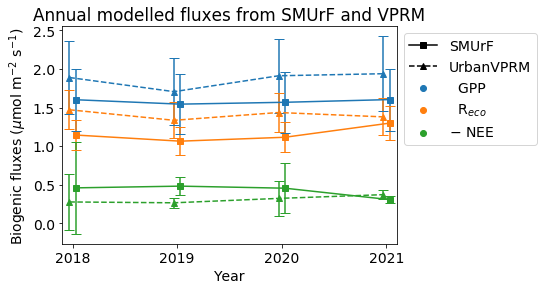

In [41]:
plt.rc('font',size=14)

plt.figure()
plt.xlim(2017.9,2021.1)
plt.xticks(range(2018,2022))
plt.errorbar(years+0.03, S_annual_avg_GPP,abs(np.array(S_annual_avg_perc_err_GPP)*np.array(S_annual_avg_GPP)),marker='s',c='tab:blue',capsize=5)
plt.errorbar(years-0.03,VPRM_annual_avg_GPP,abs(np.array(S_annual_avg_perc_err_GPP)*np.array(VPRM_annual_avg_GPP)),linestyle='--',marker='^',c='tab:blue',capsize=5)
plt.errorbar(years+0.03, S_annual_avg_Reco,abs(np.array(S_annual_avg_perc_err_Reco)*np.array(S_annual_avg_Reco)),marker='s',c='tab:orange',capsize=5)
plt.errorbar(years-0.03,VPRM_annual_avg_Reco,abs(np.array(S_annual_avg_perc_err_Reco)*np.array(VPRM_annual_avg_Reco)),linestyle='--',marker='^',c='tab:orange',capsize=5)
plt.errorbar(years+0.03, np.abs(S_annual_avg_NEE),abs(np.array(S_annual_avg_perc_err_NEE)*np.array(S_annual_avg_NEE)),marker='s',c='tab:green',capsize=5)
plt.errorbar(years-0.03,np.abs(VPRM_annual_avg_NEE),abs(np.array(S_annual_avg_perc_err_NEE)*np.array(VPRM_annual_avg_NEE)),linestyle='--',marker='^',c='tab:green',capsize=5)

plt.plot([0],[0],c='k',marker='s',label='SMUrF')
plt.plot([0],[0],c='k',linestyle='--',marker='^',label='UrbanVPRM')
plt.scatter([0],[0],c='tab:blue',label='  GPP')
plt.scatter([0],[0],c='tab:orange',label='  R$_{eco}$')
plt.scatter([0],[0],c='tab:green',label='$-$ NEE')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Year')
plt.ylabel('Biogenic fluxes ($\mu$mol m$^{-2}$ s$^{-1}$)')
plt.title('Annual modelled fluxes from SMUrF and VPRM')

# Uncomment below to save as .pdf and .png *** CHANGE PATHS & FILENAMES ***
#plt.savefig('SMUrF_VPRM_fixed_avg_interannual_avg_variability_SMUrF_avg_SMUrF_perc_err_w_lines.pdf',bbox_inches='tight')
#plt.savefig('SMUrF_VPRM_fixed_avg_interannual_avg_variability_SMUrF_avg_SMUrF_perc_err_w_lines.png',bbox_inches='tight')
plt.show()